# Experiments

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm.notebook import tqdm

1. Given a dataset, artificially introduce gaps to represent missing data.
2. Using a specific imputatations method, impute those gaps.
3. Measure the error between the orignal dataset and the imputed dataset.
4. Repeat for a range of different gaps sizes and combinations.
5. Compare between different imputations methods.

Abstract out what an 'imputer' needs to accomplish.

In [2]:
class BaseImputer():
    def __init__(self, **params):
        # Store hyperparameters and parameters for this imputer
        
        self.name = 'BaseImputer'     

    def __str__(self):
        return f"{self.name}"

    def __repr__(self):
        return "BaseImputer()"
        
    def impute(self, df):
        # impute with this imputation algorithm
        
        df_imputed = df.copy()

        return df_imputed

Implementation for different imputation methods.

In [3]:
from sklearn.impute import SimpleImputer

class MeanImputer(BaseImputer):
    def __init__(self, **params):
        # Apply hyperparameters and parameters for this imputer
        self.name = 'Mean'
        
    def __repr__(self):
        return "MeanImputer()"
        
    def impute(self, df):
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        
        df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

        return df_imputed


In [4]:
class LinearImputer(BaseImputer):
    def __init__(self):
        self.name = 'Linear'

    def __repr__(self):
        return "LinearImputer()"
        
    def impute(self, df):
        df_imputed = df.interpolate(method='linear')

        return df_imputed

In [5]:
from imputeMF import imputeMF

class MissForestImputer(BaseImputer):
    def __init__(self, max_iter=10):
        self.name = 'MissForest'

        self.max_iter = max_iter

    def __repr__(self):
        return f"MissForestImputer(max_iter={self.max_iter})"
        
    def impute(self, df):
        df_imputed = pd.DataFrame(imputeMF(df.values), columns=df.columns, index=df.index)

        return df_imputed

In [6]:
from sklearn.impute import KNNImputer as sklearnKNNImputer

class KNNImputer(BaseImputer):
    def __init__(self, n_neighbors=7):
        self.name = 'KNN'
        self.n_neighbors = 7

    def __repr__(self):
        return f"KNNImputer(n_neighbors={self.n_neighbors})"
        
    def impute(self, df):
        imputer = sklearnKNNImputer(n_neighbors=self.n_neighbors)       
        df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

        return df_imputed

In [7]:
from statsmodels.imputation.mice import MICEData

class MICEImputer(BaseImputer):
    def __init__(self, k_pmm=7, n_iterations=10):
        self.name = 'MICE'
        
        self.k_pmm = k_pmm
        self.n_iterations = n_iterations
        
    def __repr__(self):
        return f"MICEImputer(k_pmm={self.k_pmm},n_iterations={self.n_iterations})"
        
    def impute(self, df):
        mice_data = MICEData(df, k_pmm=self.k_pmm)
        mice_data.update_all(self.n_iterations)

        df_imputed = pd.DataFrame(mice_data.data.values, columns=df.columns, index=df.index)

        return df_imputed

Routine to add artificial gaps to the data sets. Note there is random seed that is kept constant to ensure the gaps are always the same for different methods. 

We could also replicate each experiment multiple times.

In [8]:
def add_artificial_gaps(df, num_sites=24, gap_length=56):
    """
    This function takes a dataframe and create contiguous gaps in place

    Returns dictionary to indicate where these gaps have been added.
    """
    
    np.random.seed(4152)

    gaps = {}
    # randomly set a n-day contiguous segment as missing for each column
    random_columns = np.random.choice(df.columns, size=num_sites, replace=False)
    
    N = len(df.values.flatten())
    m = df.isnull().values.flatten().sum()
    missing_data = m / N * 100
    
    for col in random_columns:
        # Randomly select the start of the n-day segment
        start_idx = np.random.randint(0, len(df) - gap_length)
        end_idx = start_idx + gap_length
    
        gaps[col] = [start_idx, end_idx]
    
        # Set the values in this range to NaN
        df.iloc[start_idx:end_idx, df.columns.get_loc(col)] = np.nan

    m = df.isnull().values.flatten().sum()    
    missing_fraction = float(m / N * 100)

    return {'gaps': gaps, 'num_sites': num_sites, 'gap_length': gap_length, 'missing_fraction': missing_fraction}

Driver program to run single experiment.

In [9]:
def run_experiment(imputer, minimum_missing_data=0, num_sites=24, gap_length=56, rerun_experiment=False):
    """
    This routine implements the steps
    
    1. Given a dataset, artificially introduce gaps to represent missing data.
    2. Using a specific imputatations method, impute those gaps.
    3. Measure the error between the orignal dataset and the imputed dataset.

    The results are cached in a pickle file and passed back as a dictionary.
    """

    experiment_name = f"{repr(imputer)}_missing{minimum_missing_data}_sites{num_sites}_gaplen{gap_length}"
    results_filename = f'results/{experiment_name}.pkl'

    if not rerun_experiment and os.path.exists(results_filename):
        with open(results_filename, 'rb') as f:
           results = pickle.load(f)
            
        return results
    
    # load the data
    df = pd.read_csv('dataset.csv', parse_dates=True, index_col=0)
    df = df.rename(columns = lambda x: 'S_'+x)
      
    # Calculate the percentage of non-missing data for each study site
    non_missing_percentage = df.notna().mean() * 100
    
    # Filter study sites with at least 90% non-missing data
    selected_sites = non_missing_percentage[non_missing_percentage >= minimum_missing_data].index
    df_true = df[selected_sites].copy()

    # add artifical gaps 
    df = df_true.copy()
    results = add_artificial_gaps(df, num_sites, gap_length)

    # impute the missing data using the supplied method
    df_imputed = imputer.impute(df)

    # calculate metrics
    error = df_imputed - df_true
    MAE = np.mean(abs(error))
    RMSE = np.sqrt(np.mean((error)**2))

    # capture metadata and data from the experiment
    results.update( { 'experiment_name': experiment_name,
                      'imputer_name': str(imputer),
                      'imputer_details': repr(imputer),
                      'df_true': df_true,
                      'df' : df,
                      'df_imputed': df_imputed,
                      'RMSE' : RMSE,
                      'MAE' : MAE } )

    os.makedirs('results', exist_ok=True)
    with open(f'results/{experiment_name}.pkl', 'wb') as f:
        pickle.dump(results, f)
        
    return results
                    

Example of running one experiment

In [10]:
imputer= MeanImputer()
results = run_experiment(imputer, minimum_missing_data=90, num_sites=8, gap_length=56)



Running a suite of experiments and save the summary to a file in the `results` subdirectory.

:::{warning}
The MICE and MissForest algorithm take a while to run so have been commented out below.  The results have already saved to the file `filtered_results.csv` so this next cell may be skipped.
:::

In [11]:
imputers = [LinearImputer(), 
           KNNImputer(),
           # MICEImputer(), 
           # MissForestImputer()
           ]

results_list = []
filtered_results = []
for imputer in tqdm(imputers, desc="Imputer Methods" , position=0, leave=True):
    for num_sites in tqdm([6, 12, 18], desc="num_sites", position=1, leave=False):
        for gap_length in tqdm([7, 14, 21, 35, 56, 91,], desc="gap_length", position=2, leave=False):
            result = run_experiment(imputer, minimum_missing_data=90, num_sites=num_sites, gap_length=gap_length)
            results_list.append(result)
            
            filtered_result = {k: v for k, v in result.items() if isinstance(v, (int, float, str))}
            filtered_results.append(filtered_result)

filtered_results = pd.DataFrame(filtered_results)
# filtered_results.to_csv('filtered_results.csv', index=False)


Imputer Methods:   0%|          | 0/2 [00:00<?, ?it/s]

num_sites:   0%|          | 0/3 [00:00<?, ?it/s]

gap_length:   0%|          | 0/6 [00:00<?, ?it/s]

gap_length:   0%|          | 0/6 [00:00<?, ?it/s]

gap_length:   0%|          | 0/6 [00:00<?, ?it/s]

num_sites:   0%|          | 0/3 [00:00<?, ?it/s]

gap_length:   0%|          | 0/6 [00:00<?, ?it/s]

gap_length:   0%|          | 0/6 [00:00<?, ?it/s]

gap_length:   0%|          | 0/6 [00:00<?, ?it/s]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
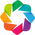

:Layout
   .NdOverlay.KNN.I  :NdOverlay   [Element]
      :Scatter   [missing_fraction]   (MAE)
   .NdOverlay.KNN.II :NdOverlay   [Element]
      :Scatter   [missing_fraction]   (RMSE)

In [12]:
import holoviews as hv
hv.extension('bokeh')

df = pd.read_csv('filtered_results.csv')

plots = []
for metric in ['MAE', 'RMSE']:
    
    scatter = hv.NdOverlay({
        imputer: hv.Scatter(df[df['imputer_name'] == imputer], 'missing_fraction', metric, label=imputer).opts(size=8)
        for imputer in df['imputer_name'].unique()
    })
    
    scatter.opts(
        title=f'{metric} vs Missing Fraction by Imputation Strategy',
        xlabel='Missing Fraction (%)',
        ylabel=metric,
        width=800,
        height=400,
        legend_position='right'
    )

    plots.append(scatter)

(plots[0] + plots[1]).cols(1)